In [2]:
# !pip install tensorflow-addons
!pip install tensorflow

In [31]:
import os 
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import tensorflow_addons as tfa 
import matplotlib.pyplot as plt

In [6]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 135s 1us/step


In [7]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [8]:
N_BATCH = 512 

RES = 32

In [17]:
class Augmentation(tf.keras.layers.Layer): 
    def __init__(self):
        super(Augmentation, self).__init__()
        
    @tf.function
    def random_execute(self, prob: float) -> bool:
        return tf.random.uniform([], 0, 1) < prob
   

In [33]:
class RandomToGrayscale(Augmentation):
    
    @tf.function
    def call(self, x : tf.Tensor) -> tf.Tensor:
        if self.random_execute(0.2):
            x = tf.image.rgb_to_grayscale(x)
            x = tf.tile(x, [1, 1, 3])
        return x
    

In [34]:
class RandomColorJitter(Augmentation):
    @tf.function
    def call(self, x : tf.Tensor) -> tf.Tensor: 
        if self.random_execute(0.8):
            x = tf.image.random_brightness(x, 0.8)
            x = tf.image.random_contrast(x, 0.4, 1.6)
            x = tf.image.random_saturation(x, 0.4, 1.6)
            x = tf.image.random_hue(x, 0.2)
        return x

In [35]:
class RandomFlip(Augmentation): 
    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor: 
        if self.random_execute(0.5): 
            x = tf.image.random_flip_left_right(x)
        return x

In [36]:
class RandomResizeCrop(Augmentation):
    
    def __init__(self, image_size): 
        super(Augmentation, self).__init__()
        self.image_size = image_size
    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        rand_size = tf.random.uniform(
            shape=[],
            minval = int(0.75 * self.image_size), 
            maxval = 1 * self.image_size, 
            dtype=tf.int32
        )
        
        crop = tf.image.random_crop(x, (rand_size, rand_size, 3))
        crop_resize = tf.image.resize(crop, (self.image_size, self.image_size)) 
        
        return crop_resize

In [37]:
class RandomSolarize(Augmentation):
    @tf.function 
    def call(self, x : tf.Tensor) -> tf.Tensor: 
        if self.random_execute(0.2): 
            x = tf.where(x < 10, x, 255-x)
        return x
    

In [38]:
class RandomBlur(Augmentation):
    @tf.function 
    def call(self, x: tf.Tensor) -> tf.Tensor:
        if self.random_execute(0.2): 
            s = np.random.random() 
            return tfa.image.gaussian_filter2d(image=x, sigma=5)
        return x

In [41]:
class RandomAugmentor(tf.keras.Model): 
    def __init__(self, image_size : int):
        super(RandomAugmentor, self).__init__()
        
        self.image_size = image_size
        self.random_resize_crop = RandomResizeCrop(image_size) 
        self.random_flip = RandomFlip()
        self.random_color_jitter = RandomColorJitter() 
        self.random_blur = RandomBlur() 
        self.random_to_grayscale = RandomToGrayscale()
        self.random_solarize = RandomSolarize() 
        
    def call(self, x : tf.Tensor) -> tf.Tensor:
        x = self.random_resize_crop(x) 
        x = self.random_flip(x)
        x = self.random_color_jitter(x) 
        x = self.random_blur(x) 
        x = self.random_to_grayscale(x) 
        x = self.random_solarize(x) 
        
        x = tf.clip_by_value(x, 0, 1)
        return x
    
bt_augmentor = RandomAugmentor(RES)

In [42]:
class BTDatasetCreator:
    def __init__(self, augmentor: RandomAugmentor, seed: int = 1024):
        self.options = tf.data.Options() 
        self.options.threading.max_intra_op_parallelism = 1 
        self.seed = seed 
        self.augmentor = augmentor 
        
    def augmented_version(self, ds: list) -> tf.data.Dataset:
        return (
            tf.data.Dataset.from_tensor_slices(ds)
            .shuffle(1000, seed=self.seed)
            .map(self.augmentor, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
            .with_options(self.options) 
        )
        
    def __call__(self, ds: list) -> tf.data.Dataset:
        a1 = self.augmented_version(ds)
        a2 = self.augmented_version(ds) 
        
        return tf.data.Dataset.zip((a1, a2)).with_options(self.options) 
    
augment_versions = BTDatasetCreator(bt_augmentor)(train_images)

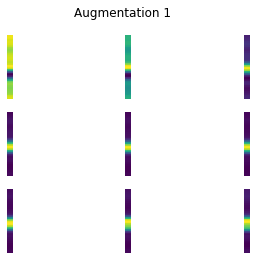

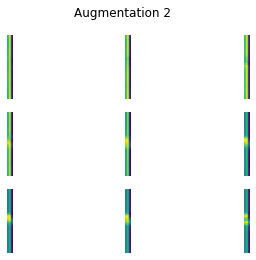

In [45]:
sample_augment_versions = iter(augment_versions)

def plot_values(batch : tuple):
    fig, axs = plt.subplots(3, 3)
    fig1, axs1 = plt.subplots(3, 3)
    
    fig.suptitle('Augmentation 1')
    fig1.suptitle('Augmentation 2')
    
    a1, a2 = batch
    
    for i in range(3): 
        for j in range(3): 
            axs[i][j].imshow(a1[3 * i + j])
            axs[i][j].axis('off')
            axs1[i][j].imshow(a2[3 * i + j])
            axs1[i][j].axis('off')
            
    plt.show() 
            
plot_values(next(sample_augment_versions))

In [46]:
class BarlowLoss(tf.keras.losses.Loss):
    def __init__(self, batch_size: int):
        super(BarlowLoss, self).__init__() 
        self.lambda_amt = 5e-3
        self.batch_size = N_BATCH
        
    def get_off_diag(self, c: tf.Tensor) -> tf.Tensor:
        zero_diag = tf.zeros(c.shape[-1])
        return tf.linalg.set_diag(c, zero_diag) 
    
    def cross_cor_matrix_loss(self, c: tf.Tensor) -> tf.Tensor:
        c_diff = tf.pow(tf.linalg.diag_part(c) - 1, 2)
        
        off_diag = tf.pow(self.get_off_diag(c), 2) * self.lambda_amt
        
        loss = tf.reduce_sum(c_diff) + tf.reduce_sum(off_diag)
        
        return loss
    
    def normalize(self, output : tf.Tensor) -> tf.Tensor:
        return (output - tf.reduce_mean(output, axis=0)) / tf.math.reduce_std(output, axis=0)
    
    def cross_corr_matrix(self, z_a_norm : tf.Tensor, z_b_norm : tf.Tensor) -> tf.Tensor:
        return (tf.transpose(z_a_norm) @ z_b_norm) / self.batch_size
    
    def call(self, z_a : tf.Tensor, z_b : tf.Tensor) -> tf.Tensor: 
        z_a_norm, z_b_norm = self.normalize(z_a), self.normalize(z_b)
        c = self.cross_corr_matrix(z_a_norm, z_b_norm)
        loss = self.cross_corr_matrix(c)
        return loss
    


In [57]:
class ResNet34:
    def identity_block(self, x, filter):
        x_skip = x 
        
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding='same')(x) 
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding='same')(x) 
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        # x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation('relu')(x)
        
        return x 
    
    def convolutional_block(self, x, filter): 
        x_skip = x 
        
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding='same')(x) 
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding='same')(x) 
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        # x = tf.keras.layers.Activation('relu')(x)
        
        x_skip = tf.keras.layers.Conv2D(filter, (1, 1), strides=(2, 2))(x_skip)
        
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation('relu')(x)
        
        return x
    
    def __call__(self, shape=(32, 32, 3)):
        x_input = tf.keras.layers.Input(shape) 
        x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input) 
        
        x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x) 
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
        
        block_layers = [3, 4, 6, 3]
        filter_size = 64
        
        for i in range(4):
            if i == 0:
                for j in range(block_layers[i]):
                    x = self.identity_block(x, filter_size)
                    
            else:
                filter_size = filter_size * 2
                x = self.convolutional_block(x, filter_size)
                
                for j in range(block_layers[i] - 1):
                    x = self.identity_block(x, filter_size)
                    
        x = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x)
        x = tf.keras.layers.Flatten()(x)
        
        return tf.keras.models.Model(inputs=x_input, outputs=x, name='ResNet34')
    
        

In [58]:
def build_twin() -> tf.keras.Model:
    n_dense_neurons = 5000 
    
    resnet = ResNet34()()
    last_layer = resnet.layers[-1].output
    
    n_layers = 2 
    for i in range(n_layers):
        dense = tf.keras.layers.Dense(n_dense_neurons, name=f'projector_dense_{i}')
        
        if i == 0:
            x = dense(last_layer)
        else:
            x = dense(x)
        x = tf.keras.layers.BatchNormalization(name=f'projector_bn+{i}')(x)
        
        x = tf.keras.layers.ReLU(name=f'projector_relu_{i}')(x)
        
    x = tf.keras.layers.Dense(n_dense_neurons, name=f'projector_dense_{n_layers}')
    
    return tf.keras.Model(resnet.input, x)

In [59]:
class BarlowModel(tf.keras.Model):
    def __init__(self): 
        super(BarlowModel, self).__init__()
        
        self.model = build_twin() 
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        
        @property
        def metrics(self):
            return [self.loss_tracker]
        
        def train_step(self, batch : tf.Tensor) -> tf.Tensor:
            y_a, y_b = batch
            
            with tf.GradientTape() as tape:
                z_a, z_b = self.model(y_a, training=True), self.model(y_b, training=True)
                loss = self.loss(z_a, z_b)
                
            gradients = tape.gradient(loss, self.model.trainable_variables) 
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.loss_tracker.update_state(loss)
            
            return {'loss' : self.loss_tracker.result()}
            

In [60]:
bm = BarlowModel() 

optimizer = tfa.optimizers.LAMB()
loss = BarlowLoss(N_BATCH)

bm.compile(optimizer=optimizer, loss=loss)

hist = bm.fit(augment_versions, epoch=1)

ValueError: Operands could not be broadcast together with shapes (10, 10, 128) (5, 5, 128)